In this notebook a modified version of the 1D discretized Jarrah's model is implemented. Diffusive terms are added in the evolution of the concentration of immune cells and several possible boundary conditions are explored. Those conditions are labelled as "evolving_sym" (edge cells evolve as well as the other ones, starting from the same initial conditions), "fixed_sym" (both in the rightmost and leftmost cells all values remain fixed and equal to the same initial conditions) and "periodic".

The following cell contains the functions used in the simulation.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import configparser
import pandas as pd
import os #per directory esterna per csv file

##################################################################################################################################
###########################################one step evolution of the system#######################################################
def one_step(t, dt, dx, H, C, M, N, D, R, H_new, C_new, M_new, N_new, D_new, R_new, i_c, par, diffusion, boundary):

    H_i, C_i, M_i, N_i, D_i, R_i = i_c
    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D, sigma, m, h = par
    D_H, D_C, D_M = diffusion

    for i in range(len(H)):

        ev_H(i, dt, dx, D_H, d_H, k1, H_i, H, M, D, H_new, boundary)
        ev_C(i, dt, dx, D_C, d_C, k2, C_i, C, H, D, C_new, boundary)
        ev_M(i, dt, dx, D_M, d_M, k3, M_i, M, D, M_new, boundary)
        ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new)
        ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new)
        ev_R(i, dt, d_D, k4, k6, M, D, R, R_new)

##################################################################################################################################
######################################################damage function#############################################################
def damage(t, sigma, m, h):

    if t==0 or t <=1e-14:       ######## Elena, ricontrollati i limiti dei float in Python
        return 0.
    else:
       return h / (t * sigma * np.sqrt(2*np.pi)) * np.exp(-(np.log(t) - m)**2 / (2. * sigma**2))

##################################################################################################################################
###################################################diffusion functions############################################################
def diff_H(i, dx, D_H, H, precision=14):
    if i == 0:
        diff = H[i+1] - H[i]
    elif i == len(H) - 1:
        diff = H[i-1] - H[i]
    else:
        diff = H[i+1] + H[i-1] - 2 * H[i]
    
#Round the relative difference to avoid small floating-point errors
    if round(diff / (abs(H[i]) + 1e-14), precision) == 0:
        return 0
    else:
        return D_H / dx * diff

def diff_C(i, dx, D_C, C, precision=14):
    if i == 0:
        diff = C[i+1] - C[i]
    elif i == len(C) - 1:
        diff = C[i-1] - C[i]
    else:
        diff = C[i+1] + C[i-1] - 2 * C[i]
    
    if round(diff / (abs(C[i]) + 1e-14), precision) == 0:
        return 0
    else:
        return D_C / dx * diff

def diff_M(i, dx, D_M, M, precision=14):
    if i == 0:
        diff = M[i+1] - M[i]
    elif i == len(M) - 1:
        diff = M[i-1] - M[i]
    else:
        diff = M[i+1] + M[i-1] - 2 * M[i]
    
    if round(diff / (abs(M[i]) + 1e-14), precision) == 0:
        return 0
    else:
        return D_M / dx * diff
##################################################################################################################################
##############################################evolution immune cells##############################################################
def ev_H(i, dt, dx, D_H, d_H, k1, H_i, H, M, D, H_new, boundary):
    
    if boundary=='evolving_sym':
        H_new[i] = H[i] + dt * (diff_H(i, dx, D_H, H) + k1 * D[i] * M[i] + d_H * (H_i - H[i]))
#in case you want a specific precision use (e.g. 7 digits):
#H_new[i] = float("{:.7f}".format(H[i] + dt * (diff_H(i, dx, D_H, H) + k1 * D[i] * M[i] + d_H * (H_i - H[i]))))
    elif boundary=='fixed_sym':
        if i==0 or i==len(H)-1:
            H_new[i] = H[i]
        else:
            H_new[i] = H[i] + dt * (diff_H(i, dx, D_H, H) + k1 * D[i] * M[i] + d_H * (H_i - H[i]))
    elif boundary=='periodic':
        if i==0:
            H_new[i] = H[i] + dt * (D_H / dx * (H[i+1] + H[len(H)-1] - 2*H[i]) + k1 * D[i] * M[i] + d_H * (H_i - H[i]))
        elif i==len(H)-1:
            H_new[i] = H[i] + dt * (D_H / dx * (H[0] + H[i-1] - 2*H[i]) + k1 * D[i] * M[i] + d_H * (H_i - H[i]))
        else:
            H_new[i] = H[i] + dt * (D_H / dx * (H[i+1] + H[i-1] - 2*H[i]) + k1 * D[i] * M[i] + d_H * (H_i - H[i]))
    else:
        print('Computation cannot be performed without specified boundary conditions.')

def ev_C(i, dt, dx, D_C, d_C, k2, C_i, C, H, D, C_new, boundary):
    
    if boundary=='evolving_sym':
        C_new[i] = C[i] + dt * (diff_C(i, dx, D_C, C) + k2 * D[i] * H[i] + d_C * (C_i - C[i]))
    elif boundary=='fixed_sym':
        if i==0 or i==len(C)-1:
            C_new[i] == C[i]
        else:
            C_new[i] = C[i] + dt * (diff_C(i, dx, D_C, C) + k2 * D[i] * H[i] + d_C * (C_i - C[i]))
    elif boundary=='periodic':
        if i==0:
            C_new[i] = C[i] + dt * (D_C / dx * (C[i+1] + C[len(C)-1] - 2*C[i]) + k2 * D[i] * H[i] + d_C * (C_i - C[i]))
        elif i==len(C)-1:
            C_new[i] = C[i] + dt * (D_C / dx * (C[0] + C[i-1] - 2*C[i]) + k2 * D[i] * H[i] + d_C * (C_i - C[i]))
        else:
            C_new[i] = C[i] + dt * (D_C / dx * (C[i+1] + C[i-1] - 2*C[i]) + k2 * D[i] * H[i] + d_C * (C_i - C[i]))
    else:
        print('Computation cannot be performed without specified boundary conditions.')
   
def ev_M(i, dt, dx, D_M, d_M, k3, M_i, M, D, M_new, boundary):
    
    if boundary=='evolving_sym':
        M_new[i] = M[i] + dt * (diff_M(i, dx, D_M, M) + k3 * D[i] * M[i] + d_M * (M_i - M[i]))
    elif boundary=='fixed_sym':
        if i==0 or i==len(M)-1:
            M_new[i] == M[i]
        else:
            M_new[i] = M[i] + dt * (diff_M(i, dx, D_M, M) + k3 * D[i] * M[i] + d_M * (M_i - M[i]))
    elif boundary=='periodic':
        if i==0:
            M_new[i] = M[i] + dt * (D_M / dx * (M[i+1] + M[len(M)-1] - 2*M[i]) + k3 * D[i] * M[i] + d_M * (M_i - M[i]))
        elif i==len(M)-1:
            M_new[i] = M[i] + dt * (D_M / dx * (M[0] + M[i-1] - 2*M[i]) + k3 * D[i] * M[i] + d_M * (M_i - M[i]))
        else:
            M_new[i] = M[i] + dt * (D_M / dx * (M[i+1] + M[i-1] - 2*M[i]) + k3 * D[i] * M[i] + d_M * (M_i - M[i]))
    else:
        print('Computation cannot be performed without specified boundary conditions.')
            
##################################################################################################################################
##########################################evolution composition muscle tissue#####################################################
def ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new):
    N_new[i] = N[i] + dt * (k4 * R[i] - N[i] * (k5 * C[i] + damage(t, sigma, m, h)))
        
def ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new):
    D_new[i] = D[i] + dt * (N[i] * (k5 * C[i] + damage(t, sigma, m, h)) - D[i] * (k6 * M[i] + d_D))
        
def ev_R(i, dt, d_D, k4, k6, M, D, R, R_new):
    R_new[i] = R[i] + dt * (D[i] * (k6 * M[i] + d_D) - k4 * R[i])
    
##################################################################################################################################
################################################store output in a csv file########################################################
def save_to_csv(output_list, column_name, directory, file_name):
#ensure the directory exists
    os.makedirs(directory, exist_ok=True)
    
#create the full file path
    file_path = os.path.join(directory, file_name)
    
#try to read the existing CSV file; if it doesn't exist, create an empty DataFrame
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        df = pd.DataFrame()

#add the specified column with the output list
    df[column_name] = output_list
    
#save the DataFrame to the specified path
    df.to_csv(file_path, index=False)
            

Here we have the actual simulation. Parameters are stored in the config.ini file. The outputs are the variables *_converted, which are lists of lists (every one storing the value of a specific state variable for every cell at a certain time step).

In [8]:
##################################################################################################################################
##################################################SIMULATION######################################################################
##################################################################################################################################

#create an instance of the ConfigParser class
config = configparser.ConfigParser()
#read the contents of the `config.ini` file, which stores the values of the parameters used in the simulation
config.read('config.ini')

#initial conditions
i_c = []
if 'initial_conditions' in config:
    for key, value in config['initial_conditions'].items():
        i_c.append(float(value))
else:
    print('Section \'initial_conditions\' is not in the configuration file')

#param
par = []
if 'parameters' in config:
    for key, value in config['parameters'].items():
        par.append(float(value))
else:
    print('Section \'parameters\' is not in the configuration file')    

#diffusion coefficients
diffusion = []
if 'diff_coeff' in config:
    for key, value in config['diff_coeff'].items():
        diffusion.append(float(value))
else:
    print('Section \'diff_coeff\' is not in the configuration file')

#simulation choices
sim = []
if 'simulation_par' in config:
    for key, value in config['simulation_par'].items():
        sim.append(float(value))
else:
    print('Section \'simulation_par\' is not in the configuration file')
dt, t_min, t_max, dx, N_cells = sim
N_cells = int(N_cells)

#boundary_conditions
if 'boundary_conditions' in config:
    for key, value in config['boundary_conditions'].items():
        boundary=value
else:
    print('Section \'boundary_conditions\' is not in the configuration file')

#create the array to store the temporal steps at which the evolution is computed
t = [t_min]

#create a list of N_cells values for each state variable and one to perform the temporal evolution
H = [i_c[0]] * (N_cells)
C = [i_c[1]] * (N_cells)
M = [i_c[2]] * (N_cells)
N = [i_c[3]] * (N_cells)
D = [i_c[4]] * (N_cells)
R = [i_c[5]] * (N_cells)

H_new = [i_c[0]] * (N_cells)
C_new = [i_c[1]] * (N_cells)
M_new = [i_c[2]] * (N_cells)
N_new = [i_c[3]] * (N_cells)
D_new = [i_c[4]] * (N_cells)
R_new = [i_c[5]] * (N_cells)

#these lists will store the values of each state variable in every cell;
#NB: I cannot just assign H_values = H because later in the code I change H
H_values = [H.copy()]
C_values = [C.copy()]
M_values = [M.copy()]
N_values = [N.copy()]
D_values = [D.copy()]
R_values = [R.copy()]

#evolution over time
for j in range(0, int((t_max-t_min)/dt)):

    one_step(t[j], dt, dx, H, C, M, N, D, R, H_new, C_new, M_new, N_new, D_new, R_new, i_c, par, diffusion, boundary)
    H, C, M, N, D, R = H_new.copy(), C_new.copy(), M_new.copy(), N_new.copy(), D_new.copy(), R_new.copy()   
    
    H_values.append(H_new.copy())
    C_values.append(C_new.copy())
    M_values.append(M_new.copy())
    N_values.append(N_new.copy())
    D_values.append(D_new.copy())
    R_values.append(R_new.copy())
    t.append((j + 1.) / (1./dt))   ###not the best way to write it, but somehow with multiplication it messes up (I've no idea why)

#Here's something else I find kind of mysterious: if I print *_values some of the lists printed
#are no more lists of float, but I get something like [np.float64(...some_number...), ...]; in order to avoid
#problems, the following line converts all type to float
H_converted = [[float(value) for value in sublist] for sublist in H_values]
C_converted = [[float(value) for value in sublist] for sublist in C_values]
M_converted = [[float(value) for value in sublist] for sublist in M_values]
N_converted = [[float(value) for value in sublist] for sublist in N_values]
D_converted = [[float(value) for value in sublist] for sublist in D_values]
R_converted = [[float(value) for value in sublist] for sublist in R_values]

#columns_H = [[row[i] for row in H_converted] for i in range(len(H_converted[0]))]
#columns_C = [[row[i] for row in C_converted] for i in range(len(C_converted[0]))]
#columns_M = [[row[i] for row in M_converted] for i in range(len(M_converted[0]))]
#columns_N = [[row[i] for row in N_converted] for i in range(len(N_converted[0]))]
#columns_D = [[row[i] for row in D_converted] for i in range(len(D_converted[0]))]
#columns_R = [[row[i] for row in R_converted] for i in range(len(R_converted[0]))]

Based on the specified boundary conditions, the following code plots the evolution in either a single cell or in two different cells. 

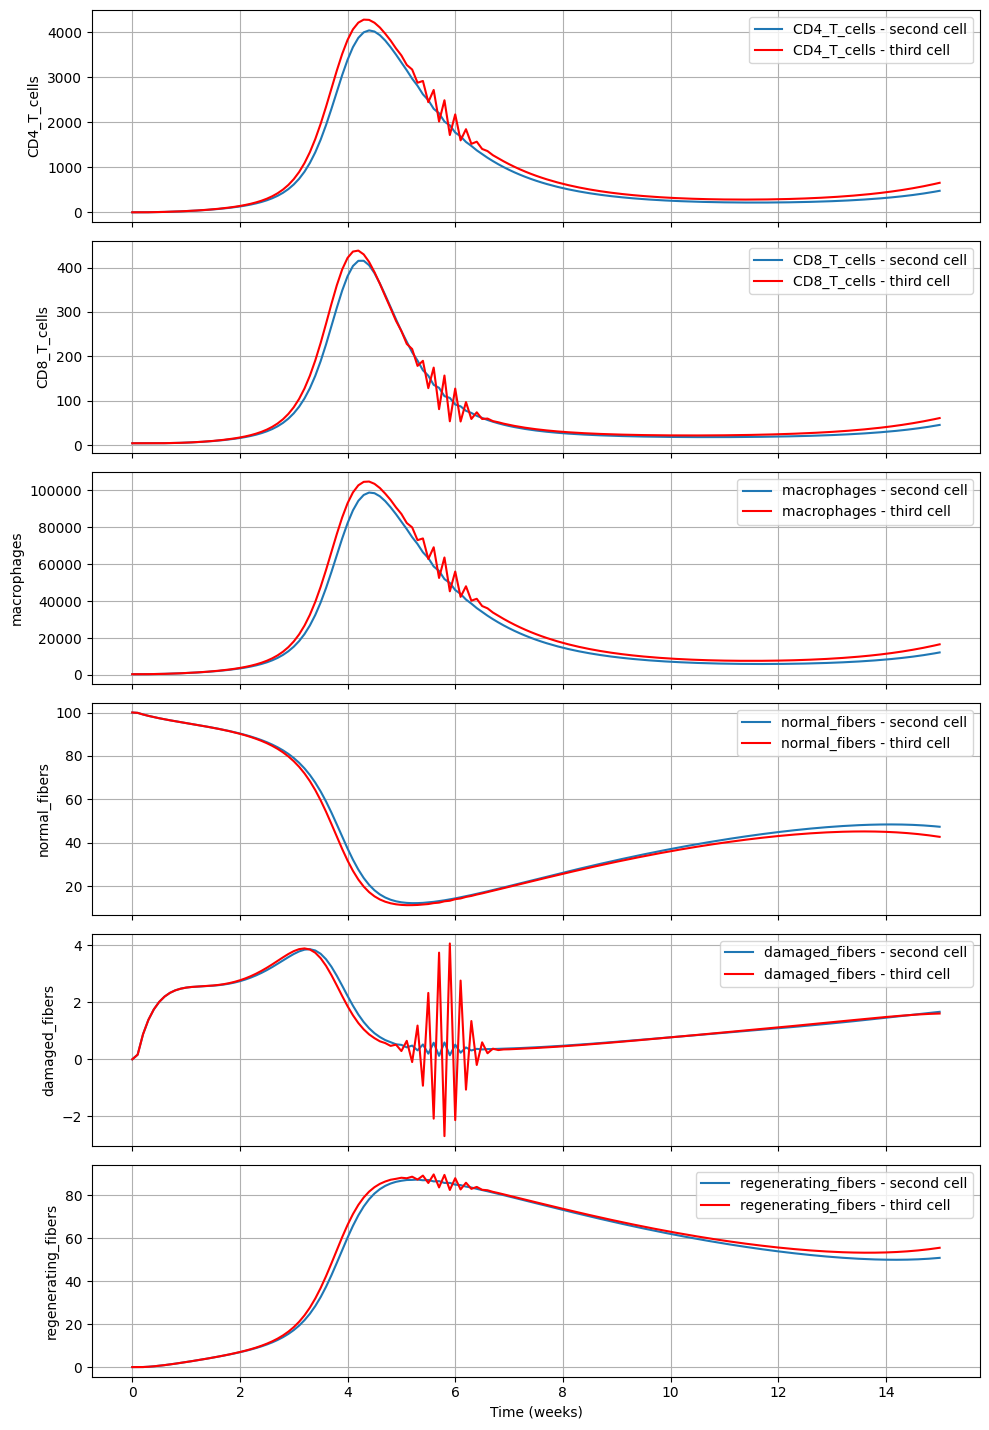

In [9]:
#use list comprehensions to extract the second and the third column
#(which correspond to the evolution in the second and the third cell)

column_H_1 = [row[1] for row in H_converted]
column_C_1 = [row[1] for row in C_converted]
column_M_1 = [row[1] for row in M_converted]
column_N_1 = [row[1] for row in N_converted]
column_D_1 = [row[1] for row in D_converted]
column_R_1 = [row[1] for row in R_converted]

column_H_2 = [row[2] for row in H_converted]
column_C_2 = [row[2] for row in C_converted]
column_M_2 = [row[2] for row in M_converted]
column_N_2 = [row[2] for row in N_converted]
column_D_2 = [row[2] for row in D_converted]
column_R_2 = [row[2] for row in R_converted]

cell_1 = [column_H_1, column_C_1, column_M_1, column_N_1, column_D_1, column_R_1]
cell_2 = [column_H_2, column_C_2, column_M_2, column_N_2, column_D_2, column_R_2]  

n_vars = len(cell_1)
labels = ['CD4_T_cells', 'CD8_T_cells', 'macrophages', 'normal_fibers', 'damaged_fibers', 'regenerating_fibers']

fig, axes = plt.subplots(n_vars, 1, figsize=(10, 15), sharex=True)

for i in range(n_vars):
    axes[i].plot(t, cell_1[i], label=f'{labels[i]} - second cell')
    if boundary == 'fixed_sym':
        axes[i].plot(t, cell_2[i], label=f'{labels[i]} - third cell', color='red')
    axes[i].set_ylabel(labels[i])
    axes[i].legend()
    axes[i].grid(True)

axes[-1].set_xlabel('Time (weeks)')

plt.tight_layout()
plt.subplots_adjust(top=0.95)

#save image in the current directory
plt.savefig(f"dt_{dt}_{boundary}.png")

plt.show()

To study how the model varies as a function of different parameters, it may be useful to save the outputs of several simulations in the same .csv file, as done in the following code.

In [ ]:
#save to csv file located in directory
directory = 'output_1D/variable_dt'
column_name = 'second_cell'

save_to_csv(column_H_1, column_name, directory, 'H.csv')
save_to_csv(column_C_1, column_name, directory, 'C.csv')
save_to_csv(column_M_1, column_name, directory, 'M.csv')
save_to_csv(column_N_1, column_name, directory, 'N.csv')
save_to_csv(column_D_1, column_name, directory, 'D.csv')
save_to_csv(column_R_1, column_name, directory, 'R.csv')


Once different simulations have been run, we can plot the outputs stored in the .csv files.

In [ ]:
suffixes = ['H', 'C', 'M', 'N', 'D', 'R']

path = {}
df = {}

which_plot = ''
while which_plot!='s' and which_plot!='p' and which_plot!='t':

    which_plot = input('Please enter "s" if you  want the different \
columns of the .csv files to be displayed in separate \
subplots, with each .csv file on a different canvas, "p" if you \
want all columns of the same .csv file in the same plot, but \
with separate images for each .csv file and "t" if you want them \
all in the same canvas.')

if which_plot=='p':

    for i in range(len(suffixes)):
        
        path[f'path_{suffixes[i]}'] = os.path.join(directory, f'{suffixes[i]}.csv')
        df[f'df_{suffixes[i]}'] = pd.read_csv(path[f'path_{suffixes[i]}'])
        plt.figure(figsize=(10, 6))
    
        for column in df[f'df_{suffixes[i]}'].columns:
            plt.plot(t, df[f'df_{suffixes[i]}'][column], label=column + ' (mm/w)')
    
        plt.xlabel('Time (weeks)')
        plt.ylabel(labels[i])
        #plt.title('Evolution in Time')
        plt.legend()
        plt.grid(True)

        #plt.savefig(f"{suffixes[i]}_diffusion.png")
        plt.show()

elif which_plot=='s':

    for i, suffix in enumerate(suffixes):
        path[f'path_{suffix}'] = os.path.join(directory, f'{suffix}.csv')
        df[f'df_{suffix}'] = pd.read_csv(path[f'path_{suffix}'])
    
        # Number of columns in the DataFrame
        num_columns = len(df[f'df_{suffix}'].columns)
    
        # Create a new figure with subplots: one subplot for each column
        fig, axes = plt.subplots(num_columns, 1, figsize=(10, 3 * num_columns), sharex=True)
    
        # If only one column, axes might not be an array, so we wrap it in a list
        if num_columns == 1:
            axes = [axes]

        # Plot each column in its respective subplot
        for ax, column in zip(axes, df[f'df_{suffix}'].columns):
            ax.plot(t, df[f'df_{suffix}'][column], label=column + ' (mm/w)')
            ax.set_ylabel(labels[i])
            #ax.set_title(f'{column}, {suffix}')
            ax.grid(True)
            ax.legend()

        axes[-1].set_xlabel('Time (weeks)')
        plt.tight_layout()

        #plt.savefig(f"{suffix}.png")
        plt.show()

elif which_plot == 't':

    #this figure will contain all subplots (one for each .csv file)
    fig, axes = plt.subplots(len(suffixes), 1, figsize=(10, 3 * len(suffixes)), sharex=True)
    
    if len(suffixes) == 1:
        axes = [axes]
    
    for i, suffix in enumerate(suffixes):
        path[f'path_{suffix}'] = os.path.join(directory, f'{suffix}.csv')
        df[f'df_{suffix}'] = pd.read_csv(path[f'path_{suffix}'])
        
        # Plot each column in the same subplot
        for column in df[f'df_{suffix}'].columns:
            axes[i].plot(t, df[f'df_{suffix}'][column], label=column + ' (mm/w)')
    
        axes[i].set_ylabel(labels[i])
        axes[i].set_title(f'Evolution in {suffix}')
        axes[i].grid(True)
        axes[i].legend()
    
    axes[-1].set_xlabel('Time (weeks)') 
    plt.tight_layout()
    
    #plt.savefig("all_suffixes_evolution.png")
    plt.show()